In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Memory management
import gc 

### Preparation of a dataset with ratings of films from raw data imbd.com

https://www.imdb.com/interfaces/

<b>title.ratings.tsv.gz</b>
<ul><li>tconst (string) - alphanumeric unique identifier of the title</li><li>averageRating – weighted average of all the individual user ratings</li><li>numVotes - number of votes the title has received</li></ul>

In [2]:
ratings = pd.read_table('input/title_ratings.tsv')

In [3]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1503
1,tt0000002,6.3,183
2,tt0000003,6.6,1149
3,tt0000004,6.3,112
4,tt0000005,6.2,1849


<b>title.basics.tsv.gz</b>
<ul><li>tconst (string) - alphanumeric unique identifier of the title</li><li>titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)</li><li>primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release</li><li>originalTitle (string) - original title, in the original language</li><li>isAdult (boolean) - 0: non-adult title; 1: adult title</li><li>startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year </li><li>endYear (YYYY) – TV Series end year. ‘\N’ for all other title types</li><li>runtimeMinutes – primary runtime of the title, in minutes</li><li>genres (string array) – includes up to three genres associated with the title</li></ul>

In [4]:
title = pd.read_table('input/title_basics.tsv')

In [5]:
title.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [6]:
movies_data = ratings.merge(title, on = 'tconst', how = 'left')

In [7]:
movies_data.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.8,1503,short,Carmencita,Carmencita,0.0,1894,\N,1,"Documentary,Short"
1,tt0000002,6.3,183,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892,\N,5,"Animation,Short"
2,tt0000003,6.6,1149,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,6.3,112,short,Un bon bock,Un bon bock,0.0,1892,\N,\N,"Animation,Short"
4,tt0000005,6.2,1849,short,Blacksmith Scene,Blacksmith Scene,0.0,1893,\N,1,"Comedy,Short"


In [8]:
# Удалим все строчки с пропущенным значением в поле "Жанр"
movies_data = movies_data.loc[movies_data['genres'] != '\\N']

In [9]:
# Удалим пропущенные значения в столбцах startYear
movies_data = movies_data.loc[movies_data['startYear'] != '\\N']
movies_data = movies_data[(movies_data['startYear'].isnull()) != True]

In [10]:
# Превратим столбец startYear в тип int
movies_data['startYear'] = pd.to_numeric(movies_data['startYear']).astype(int)

### Исследование данных

<b>Посмотрим на зависимость рейтинга от жанра фильмов</b>

In [11]:
# получим список уникальных жанров в датасете
unique_genres = []
genres = list(movies_data['genres'].str.split(','))
for col in range(len(genres)):
    if type(genres[col]) != float:
        for val in range(len(genres[col])):
            unique_genres.append(genres[col][val])

unique_genres = list(set(unique_genres))
unique_genres

['Action',
 'Comedy',
 'Animation',
 'Sport',
 'Adult',
 'Talk-Show',
 'Crime',
 'Horror',
 'Romance',
 'Documentary',
 'Western',
 'Reality-TV',
 'Film-Noir',
 'Short',
 'Sci-Fi',
 'Music',
 'History',
 'Fantasy',
 'Musical',
 'Thriller',
 'Drama',
 'Biography',
 'Family',
 'War',
 'Adventure',
 'Mystery',
 'Game-Show',
 'News']

In [12]:
# Получим среднее значения рейтинга и кол-ва голосов для каждого уникального жанра
genres_mean_rating = []
genres_mean_votes = []
for i, ganre in enumerate(unique_genres):
    genres_mean_rating.append(movies_data.loc[(movies_data['genres'].str.contains(ganre, regex=True)) == True]\
                              ['averageRating'].mean())
    genres_mean_votes.append(movies_data.loc[(movies_data['genres'].str.contains(ganre, regex=True)) == True]\
                              ['numVotes'].mean())

In [13]:
genres_rating = pd.DataFrame({'unique_genres': unique_genres, 'mean_rating': genres_mean_rating, \
                             'mean_votes': genres_mean_votes})
genres_rating.head()

,unique_genres,mean_rating,mean_votes
0,Action,6.954649,2426.248506
1,Comedy,6.960144,919.083444
2,Animation,7.068759,616.211453
3,Sport,7.014524,984.756150
4,Adult,6.339887,20.937525


Text(0.5, 0, 'Жанры')

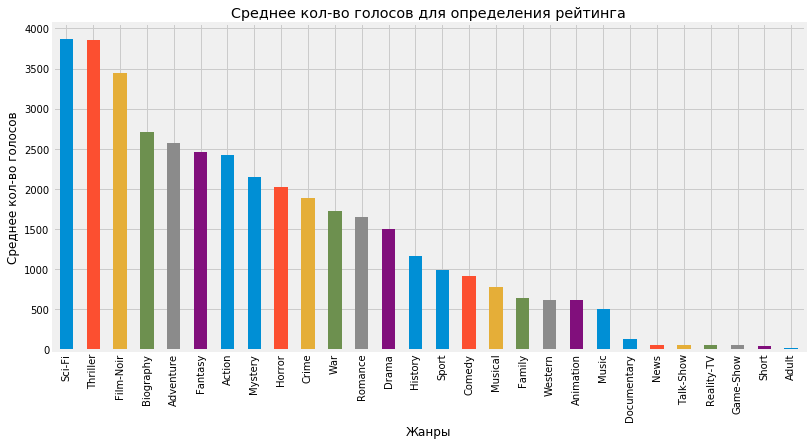

In [14]:
# Построим график по убыванию среднего кол-ва голосов для жанров
plt.figure(figsize = (12, 6))
genres_rating.set_index('unique_genres').sort_values('mean_votes', ascending = False).iloc[:, 1].plot(kind='bar');
plt.title('Среднее кол-во голосов для определения рейтинга')
plt.ylabel('Среднее кол-во голосов'); plt.xlabel('Жанры')

Этот график показывает популярность каждого жанра. Как видим самым популярным жанром являеться Фантастика и Триллер. А самыми непопулярными 6 позиций жанров справа на графике.

Text(0.5, 0, 'Жанры')

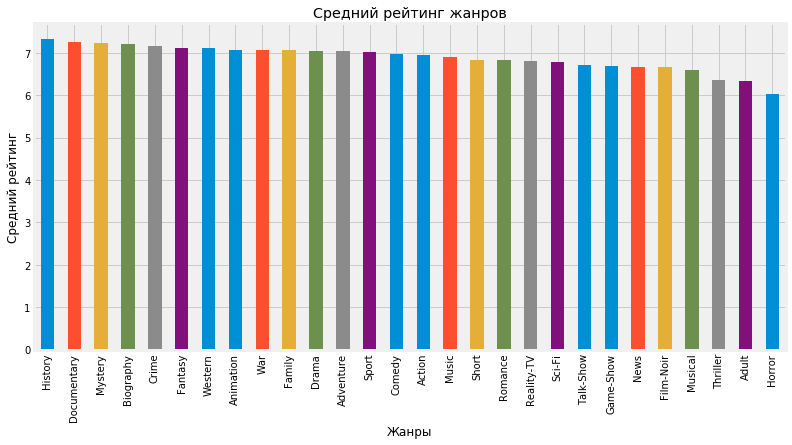

In [15]:
# Построим график по убыванию среднего рейтинга для жанров
plt.figure(figsize = (12, 6))
genres_rating.set_index('unique_genres').sort_values('mean_rating', ascending = False).iloc[:, 0].plot(kind='bar');
plt.title('Средний рейтинг жанров')
plt.ylabel('Средний рейтинг'); plt.xlabel('Жанры')

Как видим первые позиции по мах среднему рейтингу имеют жанры История и Документальное кино. Но в основном рейтинги жанров не имеют очень сильных различий. Разве, что у Хорроров самый низкий средний бал по отзывам.

In [16]:
genres_rating.set_index('unique_genres')

,mean_rating,mean_votes
unique_genres,,
Action,6.954649,2426.248506
Comedy,6.960144,919.083444
Animation,7.068759,616.211453
Sport,7.014524,984.756150
Adult,6.339887,20.937525
Talk-Show,6.701357,53.461745
Crime,7.167910,1889.780129
Horror,6.036004,2019.870758
Romance,6.821478,1647.460471


<b>Исследуем жанр "Комедия"</b>

In [17]:
# Средний рейтинг фильмов жанра только "Комедия"
comedy_only = movies_data.loc[(movies_data['genres'] == 'Comedy,Short') | (movies_data['genres'] == 'Comedy')]
comedy_only_mean = comedy_only['averageRating'].mean()
comedy_only_mean

6.878659175506494

In [18]:
# Средний рейтинг фильмов где жанр "Комедия" присутсвует только в соседстве с другими жанрами
comedy_part = movies_data.loc[((movies_data['genres'].str.contains('Comedy', regex=True)) == True)\
                & (movies_data['genres'] != 'Comedy')\
                & (movies_data['titleType'] != 'short')]
comedy_part_mean = comedy_part['averageRating'].mean()
comedy_part_mean

7.010016950433332

Как мы видим средний рейтинг жанра "Комедия" выше, если в фильме присутствует несколько жанров

In [39]:
# Сгрупируем исследуемые датафреймы по годам, с усредненеим рейтига
comedy_only_averageRating_by_year = comedy_only.groupby('startYear', as_index = False)['averageRating'].mean()\
                .rename(columns = {'averageRating': 'averageRating_by_year'})
comedy_part_averageRating_by_year = comedy_part.groupby('startYear', as_index = False)['averageRating'].mean()\
                .rename(columns = {'averageRating': 'averageRating_by_year'})

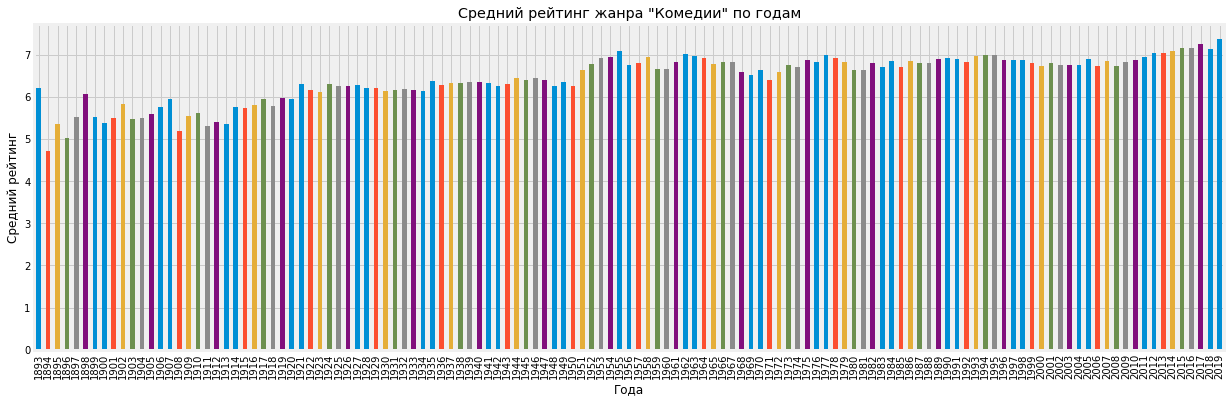

In [42]:
# График по годам для жанра "Комеди"
plt.figure(figsize = (19, 6))
comedy_only_averageRating_by_year.set_index('startYear').iloc[:, 0].plot(kind='bar');
plt.title('Средний рейтинг жанра "Комедии" по годам')
plt.ylabel('Средний рейтинг'); plt.xlabel('Года');

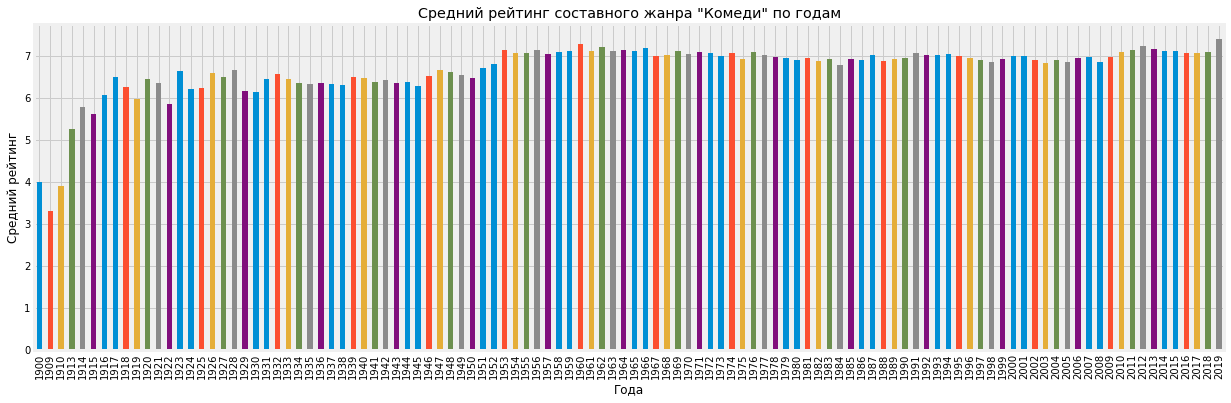

In [41]:
# График по годам для составного жанра "Комеди"
plt.figure(figsize = (19, 6))
comedy_part_averageRating_by_year.set_index('startYear').iloc[:, 0].plot(kind='bar');
plt.title('Средний рейтинг составного жанра "Комеди" по годам')
plt.ylabel('Средний рейтинг'); plt.xlabel('Года');

In [46]:
# Посмотрим коллинеарность между рейтингм и годом
comedy_only_averageRating_by_year['startYear'].corr(comedy_only_averageRating_by_year['averageRating_by_year'])

0.8833022352834359

In [47]:
# Посмотрим коллинеарность между рейтингм и годом
comedy_part_averageRating_by_year['startYear'].corr(comedy_part_averageRating_by_year['averageRating_by_year'])

0.6818111544851739

In [56]:
# Сгрупируем исследуемые датафреймы по годам, с усредненеим рейтига
comedy_only_averageRating_by_year['Votes_sum_by_year'] = comedy_only.groupby('startYear', as_index = False)['numVotes'].sum()\
                .rename(columns = {'numVotes': 'Votes_sum_by_year'})['Votes_sum_by_year']
comedy_part_averageRating_by_year['Votes_sum_by_year'] = comedy_part.groupby('startYear', as_index = False)['numVotes'].sum()\
                .rename(columns = {'numVotes': 'Votes_sum_by_year'})['Votes_sum_by_year']

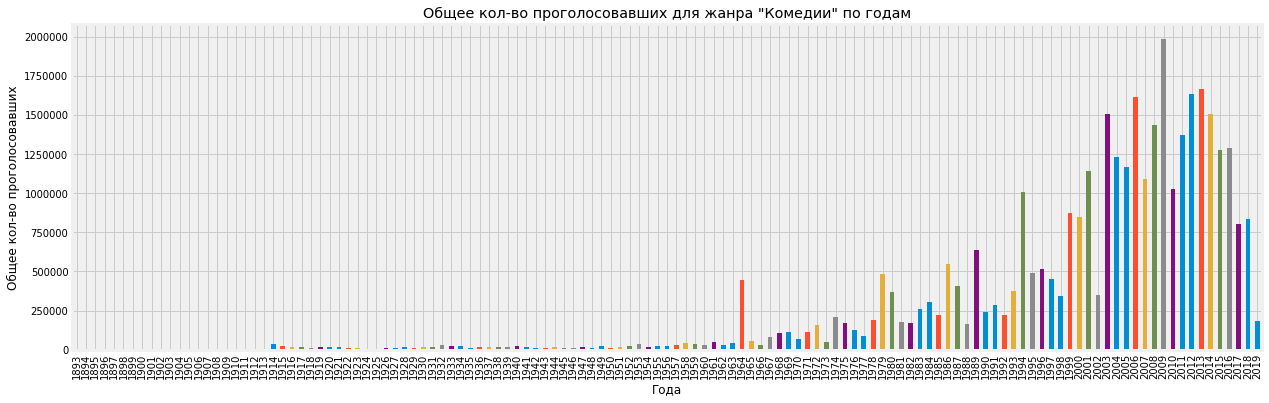

In [57]:
# График проголосовавших по годам для жанра "Комеди"
plt.figure(figsize = (19, 6))
comedy_only_averageRating_by_year.set_index('startYear').iloc[:, 1].plot(kind='bar');
plt.title('Общее кол-во проголосовавших для жанра "Комедии" по годам')
plt.ylabel('Общее кол-во проголосовавших'); plt.xlabel('Года');

Тут, как мы видим, есть пики по некоторым годам. Возможно, что в эти года выходили очень удачные комедии, поэтому кол-во голосов в эти года такие большие. Так же рейтинги послдених лет высоки, но есть тенденция, что люди все меньше смотрят комедии. Видимо, связанно с потерей интереса к этому жанру. 

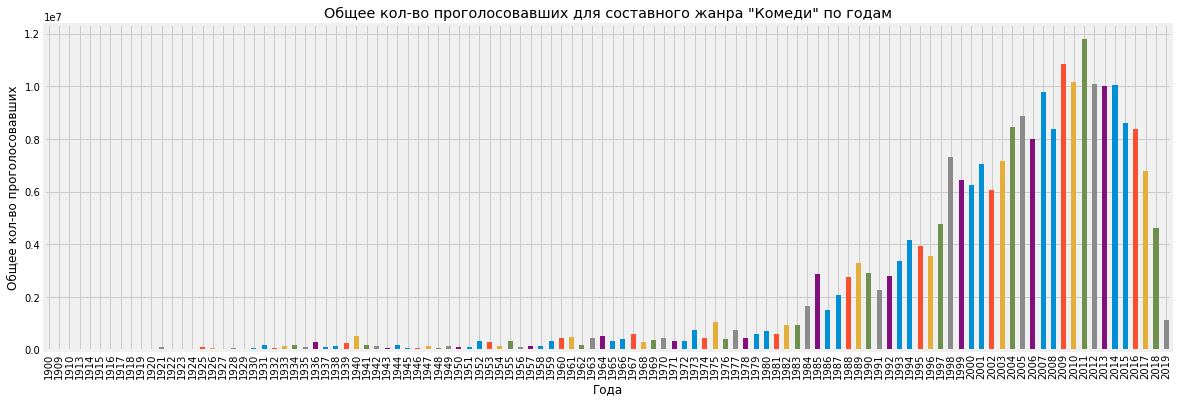

In [69]:
# График проголосовавших по годам для для составного жанра "Комеди"
plt.figure(figsize = (18, 6))
comedy_part_averageRating_by_year.set_index('startYear').iloc[:, 1].plot(kind='bar');
plt.title('Общее кол-во проголосовавших для составного жанра "Комеди" по годам')
plt.ylabel('Общее кол-во проголосовавших'); plt.xlabel('Года');

В составном жанре "Комедия" имеет меньший разброс по годам, видимо это связанно с тем, что зрители но более сильное падение интереса зрителей после 2011 года. И интерес идет только на спад.

In [73]:
movies_data_by_year = movies_data.groupby('startYear', as_index = False)['averageRating'].mean()\
                .rename(columns = {'averageRating': 'averageRating_by_year'})

In [75]:
movies_data_by_year['Votes_sum_by_year'] = movies_data.groupby('startYear', as_index = False)['numVotes'].sum()\
                .rename(columns = {'numVotes': 'Votes_sum_by_year'})['Votes_sum_by_year']

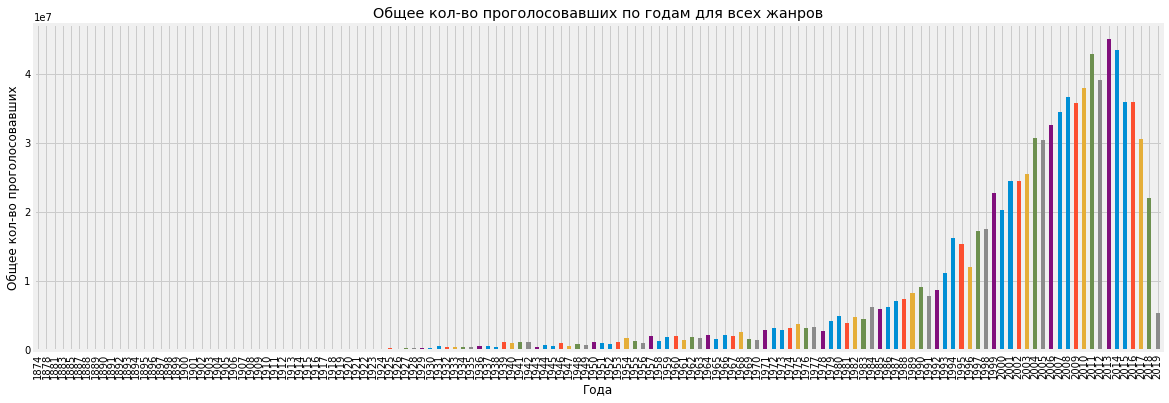

In [78]:
# График проголосовавших по годам для всех жанров
plt.figure(figsize = (18, 6))
movies_data_by_year.set_index('startYear').iloc[:, 1].plot(kind='bar');
plt.title('Общее кол-во проголосовавших по годам для всех жанров')
plt.ylabel('Общее кол-во проголосовавших'); plt.xlabel('Года');

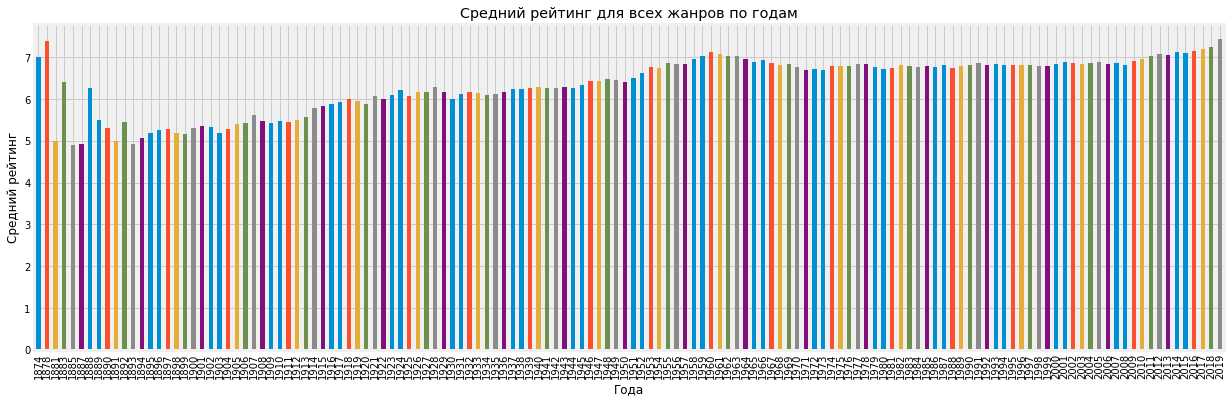

In [79]:
# График среднего рейтинга по годам для всех жанров
plt.figure(figsize = (19, 6))
movies_data_by_year.set_index('startYear').iloc[:, 0].plot(kind='bar');
plt.title('Средний рейтинг для всех жанров по годам')
plt.ylabel('Средний рейтинг'); plt.xlabel('Года');

In [80]:
# Посмотрим коллинеарность между рейтингм и годом для всех жанров
movies_data_by_year['startYear'].corr(movies_data_by_year['averageRating_by_year'])
# Есть сильная положительная связь между годом и средним рейтингом.

0.8335842581130309

Как видно из общего кол-ва голосов по годам. Тенденция на спад в кол-ве зрителей общая не только для комедийного жанра, но и для всех жанров. Тогда как рейтинги фильмов показывают небольшой рост из года в год, что значит, что отток зрителей не свзязан с низким качеством фильмов

<b>Вычислим и нарисуем линию тренда для среднего рейтинга всех жанров и жанра "Комедии" по годам </b>

Среднеквадратичная ошибка =  0.12698150796692667


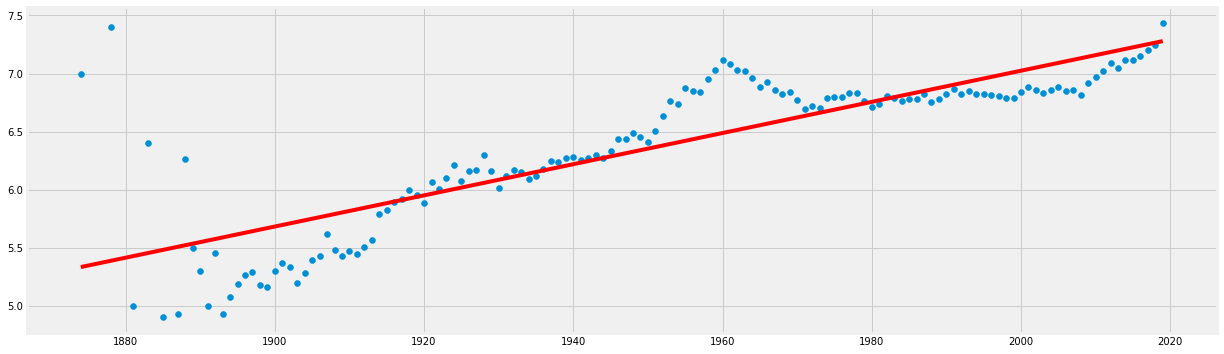

In [89]:
# График среднего рейтинга по годам для всех жанров
# Вычислим коэффициенты линейной регрессии
X = movies_data_by_year['startYear']
y = movies_data_by_year['averageRating_by_year']
b = (np.mean(X*y) - np.mean(X)*np.mean(y)) / (np.mean(X**2) - np.mean(X)**2)
a = np.mean(y) - b * np.mean(X)
plt.figure(figsize = (19, 6))
y_pred = a + X*b
plt.scatter(X, y)
plt.plot(X, y_pred, c = 'r');

mse_ = np.sum((y_pred - y)**2) / len(list(X))
print('Среднеквадратичная ошибка = ', mse_)

Среднеквадратичная ошибка =  0.06426928645185465


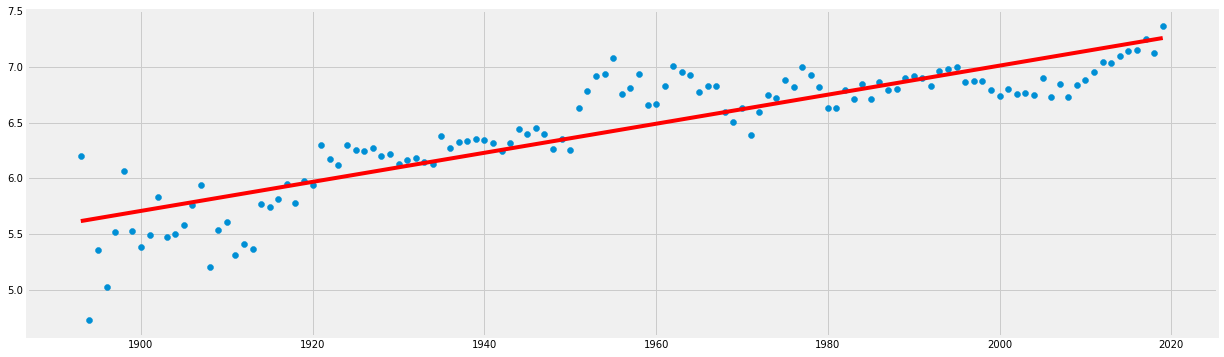

In [88]:
# График среднего рейтинга по годам для жанра "Комедии"
# Вычислим коэффициенты линейной регрессии
X = comedy_only_averageRating_by_year['startYear']
y = comedy_only_averageRating_by_year['averageRating_by_year']
b = (np.mean(X*y) - np.mean(X)*np.mean(y)) / (np.mean(X**2) - np.mean(X)**2)
a = np.mean(y) - b * np.mean(X)

plt.figure(figsize = (19, 6))
y_pred = a + X*b
plt.scatter(X, y)
plt.plot(X, y_pred, c = 'r');

mse_ = np.sum((y_pred - y)**2) / len(list(X))
print('Среднеквадратичная ошибка = ', mse_)

Как видно из линии трендов, общий рейтинг всех жанров растет быстрее из года в год, чем тренд на жанр "Комедии"

### Общие выводы

Общий вывод исследования по жанру "Комедия", без "примеси" других жанров, горорит нам, что зрительский интерес к этому жанру угасает. Переломный момент, когда начался спад находиться в 2009. А перелом зрительского интереса к жанру "Комедия" в составе других жанров произошел в 2011. При чем это не связанно с качеством фильмов. Наоборот, рейтинги фильмов по этому жанру имеют положительную тенденцию роста. Сравнивая общий интерес ко всем жанрам кино, видно, что после 2013 года интерес к индустрии в целом начал снижаться и не остановился до сих пор. А средний ретинг всех фильмов при этом растет из года в год. Из этого следует, что жанр "Комедия" находиться в общем тренде спада. Нужно более глубокое исселование, чтобы понять, почему падает общий зрительский интерес к индустрии.